In [2]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Le variabili normali sono pubbliche mentre quelle all'interno dei dizionari sono private del nome del dizionario (persona)

In [17]:
base_logica = 2
n = [base_logica**7] # 128
test = 0.5 # 50% per controllo e 50% come chiave
hacker = True
DEBUG = True

In [5]:
def printd(t):
    if DEBUG:
        print(t)

In [6]:
# Viene generato il messaggio come lista di circuiti
def generaMessaggio(qbits, basi):
    assert len(qbits) == len(basi), f'Bit logici e numero basi dovrebbero coincidere ma sono arrivati: {len(qbits)} bit logici e {len(basi)} basi'
    msg = []
    for b in zip(qbits, basi):
        qc = QuantumCircuit(1,1)
        if b[1] == 0:
            if b[0] == 1:
                qc.x(0)
        else:
            if b[0] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        msg.append(qc)
    return msg

In [7]:
# Viene decodificato il messaggio con le basi passate
def misura(msg, basi):
    assert len(msg) == len(basi), f'La lunghezza del messaggio e numero basi dovrebbero coincidere ma la lunghezza è {len(msg)} e le basi sono {len(basi)}'
    backend = Aer.get_backend('aer_simulator')
    misurazioni = []
    for q in zip(msg, basi):
        if q[1] == 1:
            q[0].h(0)
        q[0].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(q[0], shots=1, memory=True)
        risultato = aer_sim.run(qobj).result()
        m_bit = int(risultato.get_memory()[0])
        misurazioni.append(m_bit)
    return misurazioni

In [8]:
# Vengono tenuti solo i bit con base in comune tra alice e bob
def pulisciChiave(ba, bb, qbit):
    return [i[2] for i in zip(ba, bb, qbit) if i[0]==i[1]]

In [9]:
# Divide i bit in due liste in base al valore di test: una per il controllo e una da tenere come chiave
def dividiBits(bits):
    m = round(len(bits)*test)
    return bits[:m], bits[m:]
    #return [i for i in bits if i%2==0], [i for i in bits if i%2==1]
    '''
    tmp = np.random.randint(len(bits), size=m)
    sample = []
    for i in tmp:
        i = np.mod(i, len(bits))
        sample.append(bits.pop(i))
    '''
    return bits, sample

In [20]:
def main(n_tot=n, run=1):
    res = {}
    for n in n_tot:
        res_tmp = []
        for r in range(run):
            Alice = {}
            Alice['logici'] = np.random.randint(base_logica, size=n)
            Alice['basi'] = np.random.randint(base_logica, size=n) # 0->{0,1} | 1->{+,-}
            Alice['msg'] = generaMessaggio(Alice['logici'], Alice['basi'])

            # (Alice manda msg a Bob attraverso un canale quantistico es. fibra ottica)
            msg = Alice['msg']

            if hacker:
                # (Eve si è intromessa nel canale quantistico tra Alice e Bob)
                Eve = {}
                Eve['basi'] = np.random.randint(base_logica, size=n)
                Eve['msg'] = misura(msg, Eve['basi'])
                msg = generaMessaggio(Eve['msg'], Eve['basi'])

            Bob = {}
            Bob['basi'] = np.random.randint(base_logica, size=n)
            Bob['msg'] = misura(msg, Bob['basi'])

            # Alice e Bob pubblicano le basi utilizzate (canale classico dove può accedere anche Eve)
            basi_alice = list(Alice['basi'])
            basi_bob = list(Bob['basi'])

            Alice['chiave_totale'] = pulisciChiave(basi_alice, basi_bob, Alice['logici'])
            Bob['chiave_totale'] = pulisciChiave(basi_alice, basi_bob, Bob['msg'])

            Alice['chiave'], Alice['cbits'] = dividiBits(Alice['chiave_totale'])
            Bob['chiave'], Bob['cbits'] = dividiBits(Bob['chiave_totale'])

            # Alice e Bob pubblicano i bit per il controllo della chiave
            controlA = Alice['cbits']
            controlB = Bob['cbits']

            if hacker:
                res_tmp.append('non_sgamata' if controlA == controlB else 'sgamata')
            else:
                res_tmp.append(True if controlA == controlB else False)
        printd(n)
        res[str(n)] = res_tmp.count('non_sgamata')
    return res

In [19]:
n = [2**i for i in range(2,8)]
run = 1000
res = main(n, run)
print(res)

4
------------------------
8
------------------------
16
------------------------
32
------------------------
64
------------------------
128
------------------------
{'4': 757, '8': 572, '16': 350, '32': 94, '64': 7, '128': 0}


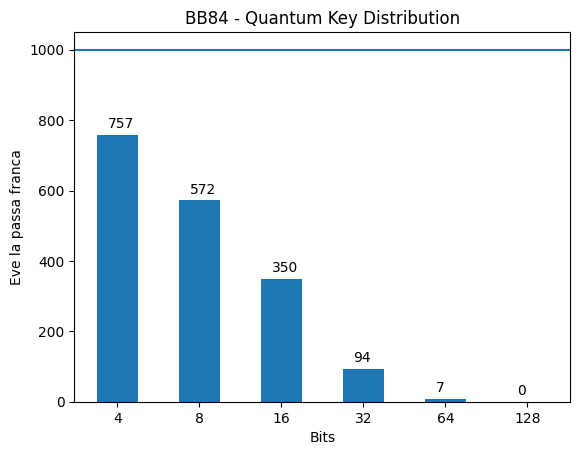

In [23]:
plt.style.use('default')
fig = plt.figure()
fig.figsize=(6,3)
ax = fig.add_subplot(111)
ax.set_xlabel('Bits')
ax.set_ylabel('Eve la passa franca')
ax.set_title('BB84 - Quantum Key Distribution')
ax.bar(list(res.keys()), res.values(), 0.5)
ax.axhline(run)
for index,data in enumerate(res.values()):
    plt.text(x=index-0.12, y=data+20 , s=f"{data}" , fontdict=dict(fontsize=10))
plt.show()
fig.savefig('plot.png', dpi=fig.dpi)